In [1]:
import numpy as np
import tensorflow as tf

from MusicRnnData import MusicRnnData

# input parameters
x_len = 50
y_len = 10
batch_size = 64
# LSTM parameters
num_layers = 2
lstm_size = 128
hidden_size = 128
# training parameters
dropout_prob = 0.5
learning_rate = 1e-1
num_steps = 50000
verbose = True
display_interval = 500
moving_avg_length = 100

# fix random seed for reproducibility
np.random.seed(7)

## Helper functions

In [2]:
from collections import deque

class MovingAverager(object):
    def __init__(self, filter_length):
        self.filter = deque([0 for _ in range(filter_length)])
        
    def insert(self, num):
        self.filter.popleft()
        self.filter.append(num)
        
    def average(self):
        return sum(self.filter)/float(len(self.filter))
    
def build_lstm_stack(num_layers, lstm_size, dropout_prob=1.0):
    def lstm_layer(lstm_size, dropout_prob=1.0):
        lstm_layer = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        return tf.contrib.rnn.DropoutWrapper(lstm_layer, output_keep_prob=dropout_prob)
    
    lstm_stack = [lstm_layer(lstm_size, dropout_prob=dropout_prob) for _ in range(num_layers)]
    return tf.contrib.rnn.MultiRNNCell(lstm_stack)

## Load the data

In [3]:
# filelist = ['a2002011001-e02.wav']
filelist = ['sine.wav']
music_data = MusicRnnData(filelist)

## Construct model

In [4]:
# input
x = tf.placeholder(tf.float32, [batch_size, x_len])
y = tf.placeholder(tf.float32, [batch_size, y_len])

# RNN Cell
lstm = build_lstm_stack(num_layers, lstm_size, dropout_prob=dropout_prob)
# add dropout here

# output layer
output, states = tf.contrib.rnn.static_rnn(lstm, [x], dtype=tf.float32)
fc_weights = tf.Variable(tf.random_normal([hidden_size, y_len]))
fc_bias = tf.Variable(tf.random_normal([y_len]))

y_ = tf.matmul(output[-1], fc_weights) + fc_bias

## Set cost function and optimizer

In [5]:
cost = tf.divide(tf.nn.l2_loss(y_ - y), y_len)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate).minimize(cost)

## Run training session

In [6]:
moving_avg = MovingAverager(moving_avg_length)

sess = tf.Session()
sess.run(tf.global_variables_initializer())
for i in range(num_steps):
    x_batch, y_batch = music_data.batch(x_len, y_len, batch_size)
    _, loss = sess.run([optimizer, cost], feed_dict={x: x_batch, y: y_batch})

    # print progress
    if verbose and (i % display_interval == 0):
        print('step: %d, training loss: %g' % (i, loss))

        # moving averager
        moving_avg.insert(loss)
        if i > moving_avg_length:
            print('moving average loss: %g' % (moving_avg.average()))

step: 0, training loss: 24.1708
step: 500, training loss: 1.07755
moving average loss: 0.252483
step: 1000, training loss: 1.48467
moving average loss: 0.26733
step: 1500, training loss: 0.0578633
moving average loss: 0.267909
step: 2000, training loss: 0.180205
moving average loss: 0.269711
step: 2500, training loss: 0.104229
moving average loss: 0.270753
step: 3000, training loss: 0.166247
moving average loss: 0.272416
step: 3500, training loss: 0.0650304
moving average loss: 0.273066
step: 4000, training loss: 0.0604396
moving average loss: 0.27367
step: 4500, training loss: 0.194444
moving average loss: 0.275615
step: 5000, training loss: 0.132141
moving average loss: 0.276936
step: 5500, training loss: 0.11329
moving average loss: 0.278069
step: 6000, training loss: 0.059732
moving average loss: 0.278666
step: 6500, training loss: 0.16424
moving average loss: 0.280309
step: 7000, training loss: 0.121908
moving average loss: 0.281528
step: 7500, training loss: 0.23048
moving averag

## Predict on sequence

In [21]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

display_interval = 100

original = music_data.convert_to_wav(music_data.tracks[0])
orig_len = original.shape[0]

prediction = original[0:x_len]
num_predictions = int((orig_len-x_len)/y_len)
x_batch = prediction
for i in range(num_predictions):
    feed_pred = np.expand_dims(x_batch, axis=0)
    feed_pred = np.repeat(feed_pred, batch_size, axis=0)
    new_y = sess.run([y_], feed_dict={x: feed_pred, y: y_batch})[0][0,:]
    prediction = np.append(prediction, new_y, axis=0)
    x_batch = np.append(x_batch[y_len:], new_y, axis=0)
    
    if (i % display_interval == 0):
        print('Iteration: %d, len(prediction) = %g' % (i, len(prediction)))
    

Iteration: 0, len(prediction) = 60
Iteration: 100, len(prediction) = 1060
Iteration: 200, len(prediction) = 2060
Iteration: 300, len(prediction) = 3060
Iteration: 400, len(prediction) = 4060
Iteration: 500, len(prediction) = 5060
Iteration: 600, len(prediction) = 6060
Iteration: 700, len(prediction) = 7060
Iteration: 800, len(prediction) = 8060
Iteration: 900, len(prediction) = 9060
Iteration: 1000, len(prediction) = 10060
Iteration: 1100, len(prediction) = 11060
Iteration: 1200, len(prediction) = 12060
Iteration: 1300, len(prediction) = 13060
Iteration: 1400, len(prediction) = 14060
Iteration: 1500, len(prediction) = 15060
Iteration: 1600, len(prediction) = 16060
Iteration: 1700, len(prediction) = 17060
Iteration: 1800, len(prediction) = 18060
Iteration: 1900, len(prediction) = 19060
Iteration: 2000, len(prediction) = 20060
Iteration: 2100, len(prediction) = 21060
Iteration: 2200, len(prediction) = 22060
Iteration: 2300, len(prediction) = 23060
Iteration: 2400, len(prediction) = 24060

## Plot predicted output

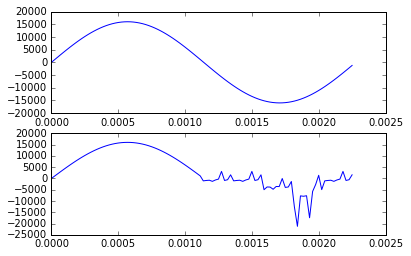

In [25]:
converted = music_data.convert_to_wav(prediction)
pred_len = converted.shape[0]
x_orig = np.linspace(0, orig_len/music_data.sample_rate, orig_len)
x_conv = np.linspace(0, pred_len/music_data.sample_rate, pred_len)
plt.subplot(211)
plt.plot(x_orig[0:300], original[0:300])
plt.subplot(212)
plt.plot(x_conv[0:300], converted[0:300])